The following topics are covered in this notebook:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting results from models
- Overfitting & hyperparameter tuning
- Making predictions on single inputs


# Garment Worker Productivity Prediction

## Project | HubbleMind

### Project Overview:

This project aims to build a machine learning model that predicts productivity levels of garment
workers based on various operational factors within a manufacturing setting. By analyzing features
like work-in-progress, overtime, incentives, and team dynamics, interns will develop models to
predict continuous productivity values, helping businesses improve their workflow efficiency and
resource management.

Dataset : Download https://drive.google.com/file/d/1Y06CTFXy0_R67YlrRrAT-M4ddPAdlgON/view | Data Source : CC BY 4.0 | UCI Archive

**Dataset:**

The dataset used for this project is the Garment Worker Productivity Dataset. It includes 1,197
records and 14 features, covering different attributes related to the garment production process,
such as targeted productivity, overtime, and the actual productivity achieved by each team. Each
row represents a record for a team on a particular day, and the target variable (actual productivity)
indicates the team's performance.

**Key Features:**

● date: Date of the record.

● quarter: The quarter of the year (e.g., Q1, Q2).

● department: Department of workers (e.g., sewing, finishing).

● team: The number representing the team.

● targeted_productivity: The target productivity (between 0 and 1).

● smv: Standard Minute Value (time required to complete the task).

● wip: Work In Progress (missing values present).

● over_time: Overtime in minutes.

● incentive: Bonus paid to workers.

● idle_time: Time during which no work was done.

● idle_men: Number of idle workers.

● no_of_style_change: Number of style changes in production.

● no_of_workers: Number of workers in the team.

● actual_productivity: Target variable representing the productivity achieved (between 0 and
1)

In [ ]:
#restart the kernel after installation
!pip install pandas-profiling numpy matplotlib seaborn --quiet

In [ ]:
!pip install opendatasets scikit-learn

In [ ]:
pip install optuna

In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')


In [2]:
#Read dataset
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

#Put the path of the dataset
garment_df = pd.read_csv('garments_worker_productivity.csv')
garment_df

date   quarter  department        day  team  targeted_productivity  \
0      1/1/2015  Quarter1      sweing   Thursday     8                   0.80   
1      1/1/2015  Quarter1  finishing    Thursday     1                   0.75   
2      1/1/2015  Quarter1      sweing   Thursday    11                   0.80   
3      1/1/2015  Quarter1      sweing   Thursday    12                   0.80   
4      1/1/2015  Quarter1      sweing   Thursday     6                   0.80   
...         ...       ...         ...        ...   ...                    ...   
1192  3/11/2015  Quarter2   finishing  Wednesday    10                   0.75   
1193  3/11/2015  Quarter2   finishing  Wednesday     8                   0.70   
1194  3/11/2015  Quarter2   finishing  Wednesday     7                   0.65   
1195  3/11/2015  Quarter2   finishing  Wednesday     9                   0.75   
1196  3/11/2015  Quarter2   finishing  Wednesday     6                   0.70   

        smv     wip  over_time  incentive  idle_time  idle_men  \
0     26.16  1108.0       7080         98        0.0         0   
1      3.94     NaN        960          0        0.0         0   
2     11.41   968.0       3660         50        0.0         0   
3     11.41   968.0       3660         50        0.0         0   
4     25.90  1170.0       1920         50        0.0         0   
...     ...     ...        ...        ...        ...       ...   
1192   2.90     NaN        960          0        0.0         0   
1193   3.90     NaN        960          0        0.0         0   
1194   3.90     NaN        960          0        0.0         0   
1195   2.90     NaN       1800          0        0.0         0   
1196   2.90     NaN        720          0        0.0         0   

      no_of_style_change  no_of_workers  actual_productivity  
0                      0           59.0             0.940725  
1                      0            8.0             0.886500  
2                      0           30.5             0.800570  
3                      0           30.5             0.800570  
4                      0           56.0             0.800382  
...                  ...            ...                  ...  
1192                   0            8.0             0.628333  
1193                   0            8.0             0.625625  
1194                   0            8.0             0.625625  
1195                   0           15.0             0.505889  
1196                   0            6.0             0.394722  

[1197 rows x 15 columns]

In [3]:
garment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

## Preparing the Data for Training

We'll perform the following steps to prepare the dataset for training:

1. Impute (fill) missing numeric values 
2. Identify input and target columns 
3. Identify numeric and categorical columns
4. Scale numeric values to the $(0, 1)$ range
5. Encode categorical columns to one-hot vectors

**Data Cleaning**

In [4]:
#Handle missing values, such as imputing the wip column using the median

column_name = 'wip' 
median_value = garment_df[column_name].median()  # Calculate the median

In [5]:
# Replace missing values
garment_df[column_name].fillna(median_value, inplace=True)

In [6]:
# Verify
print(f"Missing values after: {garment_df.isna().sum()}")

Missing values after: date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64


In [7]:
# Detect and manage outliers in columns like idle_time, incentive, and actual_productivity

def detect_and_manage_outliers(df, column_name):
    """
    Detects and manages outliers in a specified column using the IQR method.

    Args:
        df: The pandas DataFrame containing the data.
        column_name: The name of the column to analyze.

    Returns:
        pandas.DataFrame: A new DataFrame with outliers replaced by a specified value.
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median for the specified column
    df_cleaned = df.copy()  # Create a copy to avoid modifying the original
    median_value = df[column_name].median()
    df_cleaned.loc[(df_cleaned[column_name] < lower_bound) | (df_cleaned[column_name] > upper_bound), column_name] = median_value

    return df_cleaned

# Usage for 'idle_time', 'incentive', and 'actual_productivity'
columns_to_process = ['idle_time', 'incentive', 'actual_productivity']
for column in columns_to_process:
    garment_df = detect_and_manage_outliers(garment_df, column)

# Now garment_df contains the processed data with outliers replaced in the specified columns.

**Feature Engineering**

In [8]:
# Perform one-hot encoding for categorical features (e.g., quarter, department).
# ○ Extract useful date features such as month and day_of_week

# Convert the 'date' column to datetime objects
garment_df['date'] = pd.to_datetime(garment_df['date'])

# Extract month and day_of_week
garment_df['month'] = garment_df['date'].dt.month
garment_df['day_of_week'] = garment_df['date'].dt.dayofweek

# One-hot encode categorical features
categorical_cols = ['quarter', 'department','day_of_week']
garment_df = pd.get_dummies(garment_df, columns=categorical_cols, drop_first=True)

**Feature Scaling**

In [9]:
# Scale numerical features (e.g., smv, over_time) using StandardScaler for consistency
# in model training

from sklearn.preprocessing import StandardScaler
# Create a StandardScaler object
scaler = StandardScaler()

# Select numerical features to scale
numerical_features = ['smv', 'over_time', 'wip']

# Fit the scaler on the numerical features and transform them
garment_df[numerical_features] = scaler.fit_transform(garment_df[numerical_features])

In [10]:
#Dropping the targeted_productivity since it won't be used as a feature
# Drop the 'targeted_productvity' column
garment_df = garment_df.drop('targeted_productivity', axis=1)
garment_df

date        day  team       smv       wip  over_time  incentive  \
0    2015-01-01   Thursday     8  1.014552 -0.013197   0.750589         98   
1    2015-01-01   Thursday     1 -1.016778 -0.062587  -1.077682          0   
2    2015-01-01   Thursday    11 -0.333878 -0.113407  -0.271092         50   
3    2015-01-01   Thursday    12 -0.333878 -0.113407  -0.271092         50   
4    2015-01-01   Thursday     6  0.990783  0.031181  -0.790895         50   
...         ...        ...   ...       ...       ...        ...        ...   
1192 2015-03-11  Wednesday    10 -1.111853 -0.062587  -1.077682          0   
1193 2015-03-11  Wednesday     8 -1.020434 -0.062587  -1.077682          0   
1194 2015-03-11  Wednesday     7 -1.020434 -0.062587  -1.077682          0   
1195 2015-03-11  Wednesday     9 -1.111853 -0.062587  -0.826743          0   
1196 2015-03-11  Wednesday     6 -1.111853 -0.062587  -1.149379          0   

      idle_time  idle_men  no_of_style_change  no_of_workers  \
0           0.0         0                   0           59.0   
1           0.0         0                   0            8.0   
2           0.0         0                   0           30.5   
3           0.0         0                   0           30.5   
4           0.0         0                   0           56.0   
...         ...       ...                 ...            ...   
1192        0.0         0                   0            8.0   
1193        0.0         0                   0            8.0   
1194        0.0         0                   0            8.0   
1195        0.0         0                   0           15.0   
1196        0.0         0                   0            6.0   

      actual_productivity  month  quarter_Quarter2  quarter_Quarter3  \
0                0.940725      1                 0                 0   
1                0.886500      1                 0                 0   
2                0.800570      1                 0                 0   
3                0.800570      1                 0                 0   
4                0.800382      1                 0                 0   
...                   ...    ...               ...               ...   
1192             0.628333      3                 1                 0   
1193             0.625625      3                 1                 0   
1194             0.625625      3                 1                 0   
1195             0.505889      3                 1                 0   
1196             0.394722      3                 1                 0   

      quarter_Quarter4  quarter_Quarter5  department_finishing   \
0                    0                 0                      0   
1                    0                 0                      1   
2                    0                 0                      0   
3                    0                 0                      0   
4                    0                 0                      0   
...                ...               ...                    ...   
1192                 0                 0                      0   
1193                 0                 0                      0   
1194                 0                 0                      0   
1195                 0                 0                      0   
1196                 0                 0                      0   

      department_sweing  day_of_week_1  day_of_week_2  day_of_week_3  \
0                     1              0              0              1   
1                     0              0              0              1   
2                     1              0              0              1   
3                     1              0              0              1   
4                     1              0              0              1   
...                 ...            ...            ...            ...   
1192                  0              0              1              0   
1193                  0              0              1      

In [11]:
garment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   day                    1197 non-null   object        
 2   team                   1197 non-null   int64         
 3   smv                    1197 non-null   float64       
 4   wip                    1197 non-null   float64       
 5   over_time              1197 non-null   float64       
 6   incentive              1197 non-null   int64         
 7   idle_time              1197 non-null   float64       
 8   idle_men               1197 non-null   int64         
 9   no_of_style_change     1197 non-null   int64         
 10  no_of_workers          1197 non-null   float64       
 11  actual_productivity    1197 non-null   float64       
 12  month                  1197 non-null   int64         
 13  qua

## Exploratory Data Analysis (EDA)

Let us view the dataset using plots

**Target variable analysis**

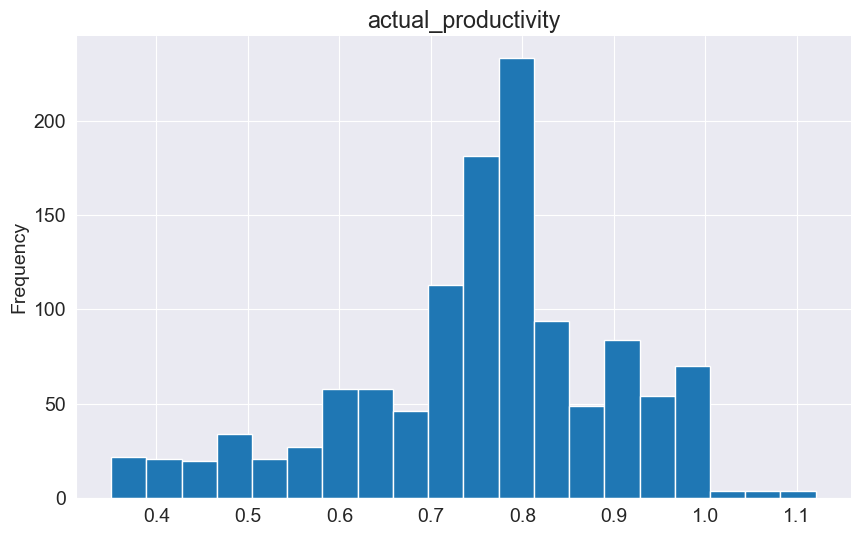

In [12]:
# @title actual_productivity

from matplotlib import pyplot as plt
garment_df['actual_productivity'].plot(kind='hist', bins=20, title='actual_productivity')
plt.gca().spines[['top', 'right',]].set_visible(False)

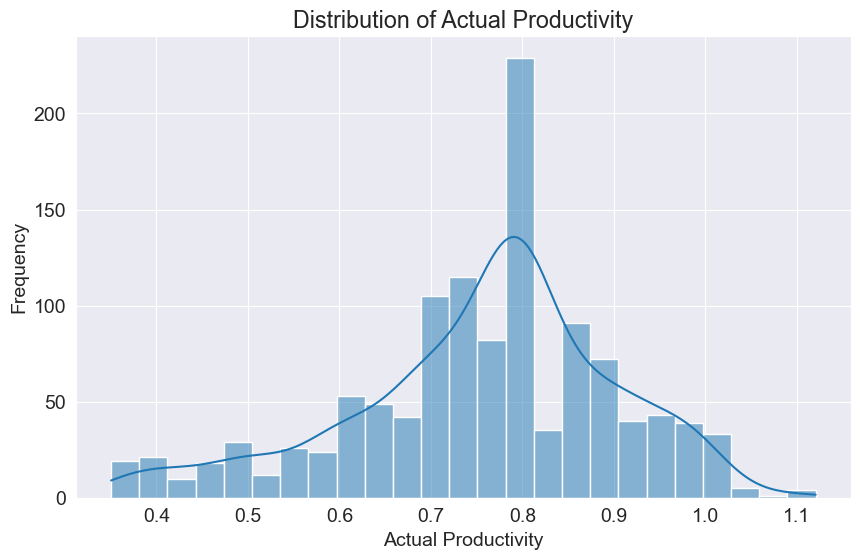

count    1197.000000
mean        0.756478
std         0.146340
min         0.350417
25%         0.684889
50%         0.773333
75%         0.850253
max         1.120437
Name: actual_productivity, dtype: float64


In [13]:
# Analyze the distribution of actual_productivity to understand its spread.

# Analyze the distribution of 'actual_productivity'
plt.figure(figsize=(10, 6))
sns.histplot(garment_df['actual_productivity'], kde=True)
plt.title('Distribution of Actual Productivity')
plt.xlabel('Actual Productivity')
plt.ylabel('Frequency')
plt.show()

# Calculate descriptive statistics for 'actual_productivity'
print(garment_df['actual_productivity'].describe())

**Feature relationships**

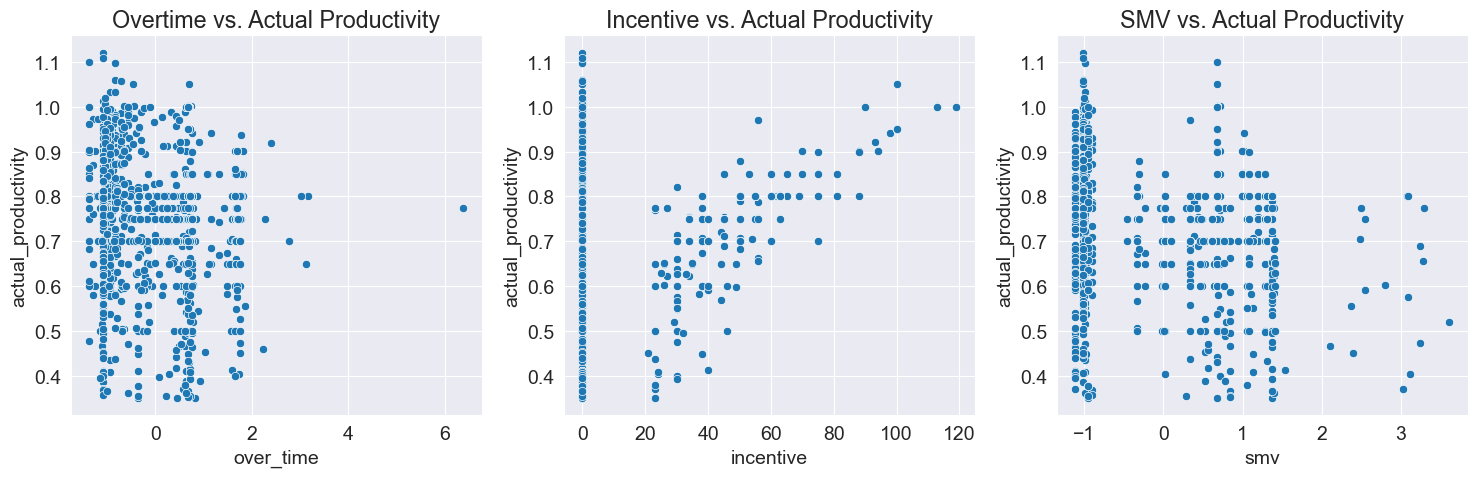

In [14]:
# Use scatter plots and box plots to visualize the relationships between
# actual_productivity and features like over_time, incentive, and smv

# Create scatter plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='over_time', y='actual_productivity', data=garment_df)
plt.title('Overtime vs. Actual Productivity')

plt.subplot(1, 3, 2)
sns.scatterplot(x='incentive', y='actual_productivity', data=garment_df)
plt.title('Incentive vs. Actual Productivity')

plt.subplot(1, 3, 3)
sns.scatterplot(x='smv', y='actual_productivity', data=garment_df)
plt.title('SMV vs. Actual Productivity')

plt.tight_layout()
plt.show()


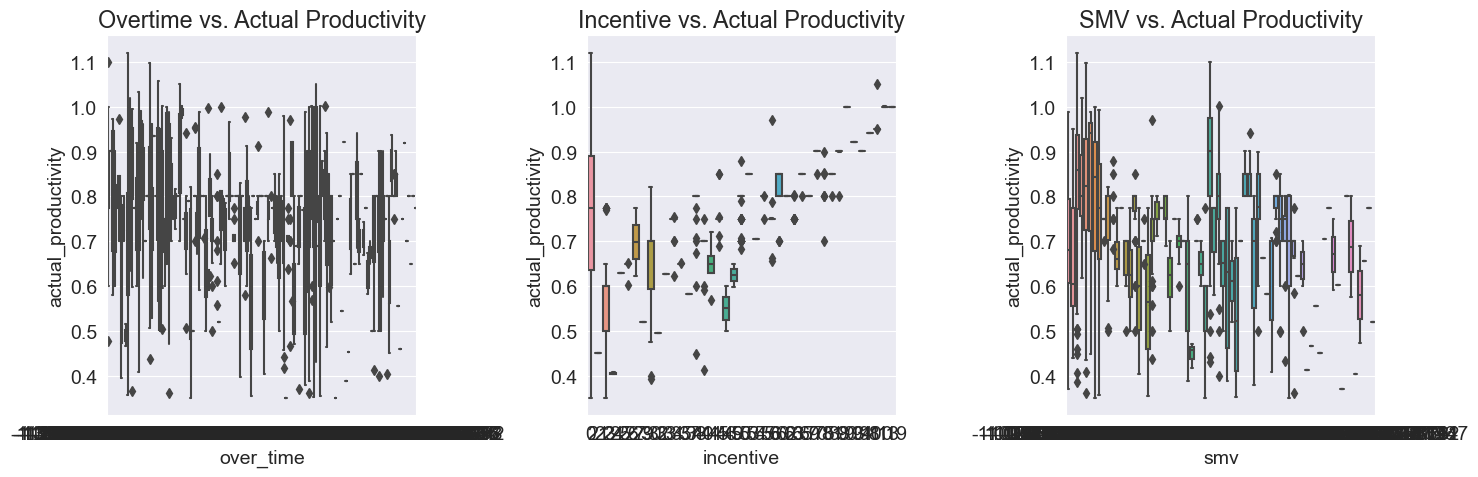

In [15]:
# Create box plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='over_time', y='actual_productivity', data=garment_df)
plt.title('Overtime vs. Actual Productivity')

plt.subplot(1, 3, 2)
sns.boxplot(x='incentive', y='actual_productivity', data=garment_df)
plt.title('Incentive vs. Actual Productivity')

plt.subplot(1, 3, 3)
sns.boxplot(x='smv', y='actual_productivity', data=garment_df)
plt.title('SMV vs. Actual Productivity')

plt.tight_layout()
plt.show()

**Correlation Analysis**

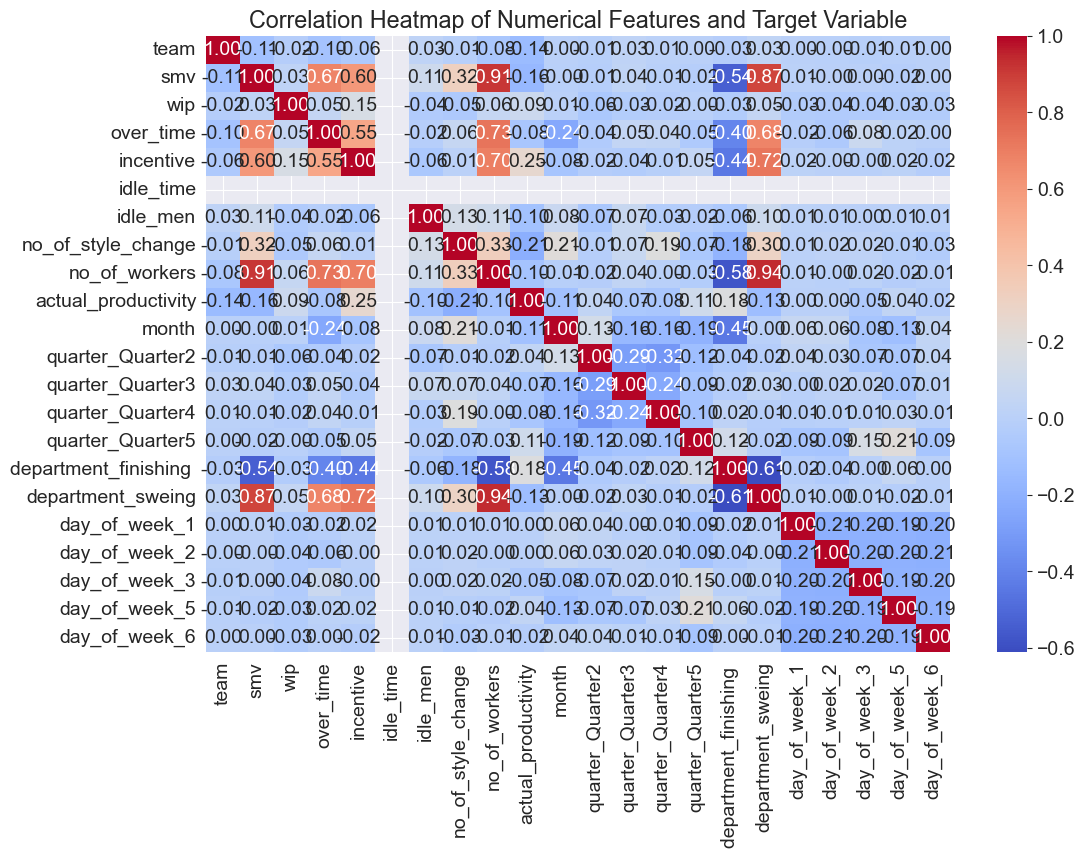

In [16]:
# Generate a correlation heatmap to see relationships between numerical features
# and the target variable

# Calculate the correlation matrix
# Select only numerical features for correlation calculation
numerical_features = garment_df.select_dtypes(include=np.number).columns
correlation_matrix = garment_df[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features and Target Variable')
plt.show()

**EDA Summary**

In [17]:
import plotly.express as px # Import the plotly.express module and assign it to the alias 'px'
px.histogram(garment_df, x='incentive', title='incentive vs. actual_productivty', color='actual_productivity')

In [18]:
# Instead of a fixed sample size, calculate a sample size
# based on the actual number of rows in the DataFrame.
# For example, to take a sample of 80% of the data:
sample_size = int(0.8 * len(garment_df))

# Then, use this calculated sample size in your scatter plot:
px.scatter(garment_df.sample(sample_size),
           title='incentive vs team',
           x='incentive',
           y='team',
           color='actual_productivity')

In [19]:
garment_df.head()

date       day  team       smv       wip  over_time  incentive  \
0 2015-01-01  Thursday     8  1.014552 -0.013197   0.750589         98   
1 2015-01-01  Thursday     1 -1.016778 -0.062587  -1.077682          0   
2 2015-01-01  Thursday    11 -0.333878 -0.113407  -0.271092         50   
3 2015-01-01  Thursday    12 -0.333878 -0.113407  -0.271092         50   
4 2015-01-01  Thursday     6  0.990783  0.031181  -0.790895         50   

   idle_time  idle_men  no_of_style_change  no_of_workers  \
0        0.0         0                   0           59.0   
1        0.0         0                   0            8.0   
2        0.0         0                   0           30.5   
3        0.0         0                   0           30.5   
4        0.0         0                   0           56.0   

   actual_productivity  month  quarter_Quarter2  quarter_Quarter3  \
0             0.940725      1                 0                 0   
1             0.886500      1                 0                 0   
2             0.800570      1                 0                 0   
3             0.800570      1                 0                 0   
4             0.800382      1                 0                 0   

   quarter_Quarter4  quarter_Quarter5  department_finishing   \
0                 0                 0                      0   
1                 0                 0                      1   
2                 0                 0                      0   
3                 0                 0                      0   
4                 0                 0                      0   

   department_sweing  day_of_week_1  day_of_week_2  day_of_week_3  \
0                  1              0              0              1   
1                  0              0              0              1   
2                  1              0              0              1   
3                  1              0              0              1   
4                  1              0              0              1   

   day_of_week_5  day_of_week_6  
0              0              0  
1              0              0  
2              0              0  
3              0              0  
4              0              0

In [20]:
garment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   day                    1197 non-null   object        
 2   team                   1197 non-null   int64         
 3   smv                    1197 non-null   float64       
 4   wip                    1197 non-null   float64       
 5   over_time              1197 non-null   float64       
 6   incentive              1197 non-null   int64         
 7   idle_time              1197 non-null   float64       
 8   idle_men               1197 non-null   int64         
 9   no_of_style_change     1197 non-null   int64         
 10  no_of_workers          1197 non-null   float64       
 11  actual_productivity    1197 non-null   float64       
 12  month                  1197 non-null   int64         
 13  qua

## Machine Learning Model Selection and Evaluation

**Data splitting**

In [21]:
print(garment_df.columns)

Index(['date', 'day', 'team', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
       'actual_productivity', 'month', 'quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing ',
       'department_sweing', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_5', 'day_of_week_6'],
      dtype='object')


However, while working with dates, it's often a better idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the Date column in the dataset to create another column for month. We'll pick the first 80% of the days as training and the last 20% for test set.

In [22]:
# Split the data into training and test sets (80% training, 20% testing).

# Convert the 'date' column to datetime objects
garment_df['date'] = pd.to_datetime(garment_df['date'])


# Now, split the data into training and test sets
# Sort the DataFrame by date
garment_df = garment_df.sort_values(by='date')

# Calculate split points based on the date
train_size = int(0.8 * len(garment_df))
train_df = garment_df[:train_size]
test_df = garment_df[train_size:]

print('train_df.shape :', train_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (957, 24)
test_df.shape : (240, 24)


In [23]:
#Saving the cleaned data as a new dataset
garment_df.to_csv('new_garment_df.csv', index=False)

**Model Selection and Training**

**Hyperparameter Tuning**

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
import optuna

# Create dummy data
np.random.seed(0)
data = {
    'team': np.random.randint(1, 5, size=100),
    'smv': np.random.rand(100),
    'wip': np.random.randint(100, 500, size=100),
    'over_time': np.random.randint(0, 5, size=100),
    'incentive': np.random.rand(100),
    'idle_time': np.random.rand(100),
    'idle_men': np.random.randint(0, 10, size=100),
    'no_of_style_change': np.random.randint(0, 3, size=100),
    'no_of_workers': np.random.randint(20, 50, size=100),
    'month': np.random.randint(1, 13, size=100),
    'day_of_week_1': np.random.randint(0, 2, size=100),
    'day_of_week_2': np.random.randint(0, 2, size=100),
    'day_of_week_3': np.random.randint(0, 2, size=100),
    'day_of_week_5': np.random.randint(0, 2, size=100),
    'day_of_week_6': np.random.randint(0, 2, size=100),
    'actual_productivity': np.random.rand(100)
}
df = pd.DataFrame(data)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define input features (X) and target variable (y)
input_cols = ['team', 'smv', 'wip', 'over_time', 'incentive', 'idle_time',
              'idle_men', 'no_of_style_change', 'no_of_workers', 'month',
              'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_5',
              'day_of_week_6']
target_col = 'actual_productivity'

X_train = train_df[input_cols].copy()  # Create a copy of the slice
y_train = train_df[target_col].copy()
X_test = test_df[input_cols].copy()  # Create a copy of the slice
y_test = test_df[target_col].copy()

# Define the models (including XGBoost)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

# Define hyperparameter grids for each model
param_grids = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Ridge Regression': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'Support Vector Regressor': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'XGBoost': {
       'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

results = {}
results_base = {}
tuned_models = {}

# Evaluate base models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_base = model.predict(X_test)
    mse_base = mean_squared_error(y_test, y_pred_base)
    mae_base = mean_absolute_error(y_test, y_pred_base)  # Evaluate on the test data
    r2_base = r2_score(y_test, y_pred_base)
    results_base[model_name] = {'mse_base': mse_base, 'r2_base': r2_base, 'mae_base': mae_base}

# Perform hyperparameter tuning and model training
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids[model_name]
    results[model_name] = {}

    if param_grid and model_name != "XGBoost":  # Only tune if there are hyperparameters to tune and not XGBoost
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        results[model_name].update({'best_params': best_params})
    elif model_name == "XGBoost":
        # --- XGBoost Hyperparameter Tuning with Optuna ---
        print("\nTuning hyperparameters for XGBoost with Optuna...")

        def objective(trial):
            """Objective function for Optuna to optimize."""
            xgb_params = {
                'objective': 'reg:squarederror',  # For regression
                'eval_metric': 'rmse',  # Evaluation metric
                'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
                'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
                'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            }

            if xgb_params['booster'] in ['gbtree', 'dart']:
                xgb_params['max_depth'] = trial.suggest_int('max_depth', 3, 10)
                xgb_params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 10)
                xgb_params['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
                xgb_params['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)
                xgb_params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
                xgb_params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.5, 1.0)

            if xgb_params['booster'] == 'dart':
                xgb_params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
                xgb_params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
                xgb_params['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)

            bst = xgb.train(xgb_params, dtrain)
            preds = bst.predict(dtest)
            mse = mean_squared_error(y_test, preds)
            return mse

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=200)  # you can increase this number for better tuning

        best_params_xgb = study.best_params
        best_mse_xgb = study.best_value

        # Train the best XGBoost model
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        best_model_xgb = xgb.train(best_params_xgb, dtrain)

        # Evaluate the best XGBoost model
        y_pred_xgb = best_model_xgb.predict(dtest)
        mse_xgb = mean_squared_error(y_test, y_pred_xgb)
        mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
        r2_xgb = r2_score(y_test, y_pred_xgb)

        results['XGBoost'] = {'best_params': best_params_xgb, 'mse': mse_xgb, 'r2': r2_xgb, 'mae': mae_xgb}

        # add r2_base for XGBoost
        results['XGBoost'].update({'r2_base': results_base["XGBoost"]['r2_base']})
        results['XGBoost'].update({'mae_base': results_base["XGBoost"]['mae_base']})

    else:
        best_model = model  # No tuning needed
        best_model.fit(X_train, y_train)

    if model_name != "XGBoost":  # to prevent doing this calculation twice
        # Evaluate the best model on the test set
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[model_name].update({'mse': mse, 'r2': r2, 'mae': mae})

        # Add base model results to the 'results' dictionary
        if model_name in results_base:
            results[model_name].update({'r2_base': results_base[model_name]['r2_base']})
            results[model_name].update({'mae_base': results_base[model_name]['mae_base']})



Tuning hyperparameters for Linear Regression...
Tuning hyperparameters for Ridge Regression...
Tuning hyperparameters for Lasso Regression...
Tuning hyperparameters for Random Forest...
Tuning hyperparameters for Gradient Boosting...
Tuning hyperparameters for Support Vector Regressor...


[I 2024-12-28 22:42:36,182] A new study created in memory with name: no-name-550f1f6f-dc6a-4c00-80a8-820446937f90
[I 2024-12-28 22:42:36,229] Trial 0 finished with value: 0.07860029492488038 and parameters: {'booster': 'dart', 'lambda': 0.002653400284123321, 'alpha': 0.6273468432490678, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 9.257516474773991e-06, 'eta': 0.0005237010463426201, 'subsample': 0.5214537054316778, 'colsample_bytree': 0.6660299229367252, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.9320100784789712e-07}. Best is trial 0 with value: 0.07860029492488038.
[I 2024-12-28 22:42:36,287] Trial 1 finished with value: 0.10269395004894999 and parameters: {'booster': 'dart', 'lambda': 0.026512684806233765, 'alpha': 0.8039121016614098, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.03517046268576992, 'eta': 0.2744153456369905, 'subsample': 0.7706761572763319, 'colsample_bytree': 0.585447014505488, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rat

Tuning hyperparameters for XGBoost...

Tuning hyperparameters for XGBoost with Optuna...


C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:36,397] Trial 3 finished with value: 0.07851166329600208 and parameters: {'booster': 'gblinear', 'lambda': 2.1959133542003617e-07, 'alpha': 1.3825885536384918e-08, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.00989511501593987, 'eta': 3.7106574586909783e-08, 'subsample': 0.617486576820256, 'colsample_bytree': 0.9398078660446412}. Best is trial 3 with value: 0.07851166329600208.
[I 2024-12-28 22:42:36,449] Trial 4 finished with value: 0.07851172402941345 and parameters: {'booster': 'dart', 'lambda': 0.44705233412217243, 'alpha': 4.731056910676042e-06, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.45133414460591254, 

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:37,780] Trial 16 finished with value: 0.07851166842907618 and parameters: {'booster': 'gblinear', 'lambda': 0.00015914909252518047, 'alpha': 8.383842135611697e-05, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 4.2321083015821404e-07, 'eta': 8.905066955841896e-08, 'subsample': 0.6794497854539367, 'colsample_bytree': 0.8035291174216275}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740:

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:39,582] Trial 28 finished with value: 0.08211899507530117 and parameters: {'booster': 'gblinear', 'lambda': 3.8604829735084794e-07, 'alpha': 3.66487223693803e-07, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 4.207738722576269e-05, 'eta': 0.03212074284693603, 'subsample': 0.6342651915493727, 'colsample_bytree': 0.9992438177641051}. Best is trial 11 with value: 0.07851165935745526.
[I 2024-12-28 22:42:39,742] Trial 29 finished with value: 0.078551780624983 and parameters: {'booster': 'gbtree', 'lambda': 4.901667263706943e-08, 'alpha': 0.0011505364771091096, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 1.0292416568767784

[I 2024-12-28 22:42:41,472] Trial 40 finished with value: 0.07851168018432916 and parameters: {'booster': 'dart', 'lambda': 0.36141574456192493, 'alpha': 8.75845018383425e-07, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.002550937226385601, 'eta': 9.846198263591388e-08, 'subsample': 0.7040916817888869, 'colsample_bytree': 0.7006336687982405, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0010344009125538426}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:41,619] Trial 41 finished with value: 0.07851165935745526 and parameters: {'booster': 'gblinear', 'lambda': 1.1368015236027116e-05, 'alpha': 4.

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:43,350] Trial 52 finished with value: 0.11399505325550192 and parameters: {'booster': 'gblinear', 'lambda': 1.6821947589434185e-06, 'alpha': 5.199072339808407e-07, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.0008374616461704381, 'eta': 0.866749784194216, 'subsample': 0.8130531412984281, 'colsample_bytree': 0.9811461751773048}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:45,231] Trial 64 finished with value: 0.07851166881818625 and parameters: {'booster': 'gblinear', 'lambda': 0.0006028649731952793, 'alpha': 1.0285755098877032e-06, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 3.336998734129585e-05, 'eta': 6.074890918080773e-08, 'subsample': 0.6756572666065873, 'colsample_bytree': 0.7454756157166789}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:47,118] Trial 76 finished with value: 0.07851166622733266 and parameters: {'booster': 'gblinear', 'lambda': 2.9289497752494824e-06, 'alpha': 1.7028397490384374e-08, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.681834361815051, 'eta': 7.972720913043198e-08, 'subsample': 0.7573919682473267, 'colsample_bytree': 0.8028841050724876}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
P

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:49,418] Trial 90 finished with value: 0.07851165935745526 and parameters: {'booster': 'gblinear', 'lambda': 1.4489922177988428e-05, 'alpha': 3.663676652129334e-05, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 4.455827395875947e-06, 'eta': 2.6650001323079645e-08, 'subsample': 0.7988621361842754, 'colsample_bytree': 0.9877677160590999}. Best is trial 11 with value: 0.07851165935745526.
[I 2024-12-28 22:42:49,589] Trial 91 finished with value: 0.07851165935745526 and parameters: {'booster': 'dart', 'lambda': 4.716588436249794e-06, 'alpha': 6.096096347495525e-07, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.007744654403

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:51,764] Trial 104 finished with value: 0.0785146921493148 and parameters: {'booster': 'gblinear', 'lambda': 3.3540986246393823e-06, 'alpha': 3.5559268379463323e-07, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.0001493343914369714, 'eta': 3.1018690795612865e-05, 'subsample': 0.6794430738863106, 'colsample_bytree': 0.9380903722547593}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:53,684] Trial 116 finished with value: 0.07851166842907618 and parameters: {'booster': 'gblinear', 'lambda': 1.0886244619163185e-05, 'alpha': 1.373665917600587e-07, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 3.385688369525214e-07, 'eta': 8.864125075583198e-08, 'subsample': 0.8512002402945477, 'colsample_bytree': 0.9854655525597653}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740:

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:55,670] Trial 128 finished with value: 0.07851165935745526 and parameters: {'booster': 'gblinear', 'lambda': 7.50642278194453e-06, 'alpha': 1.0186292198087955e-07, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.01889262524625009, 'eta': 1.4313157571621542e-08, 'subsample': 0.752277810970762, 'colsample_bytree': 0.7551553022412409}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
P

[I 2024-12-28 22:42:57,677] Trial 140 finished with value: 0.07851165935745526 and parameters: {'booster': 'dart', 'lambda': 2.3523523646003717e-05, 'alpha': 8.41376965727614e-07, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 6.974723194468502e-06, 'eta': 1.8680097480996444e-08, 'subsample': 0.7903058944143851, 'colsample_bytree': 0.5012523385388746, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2090160608940287}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:57,845] Trial 141 finished with value: 0.07851165935745526 and parameters: {'booster': 'gblinear', 'lambda': 1.1065564492641418e-07, 'alp

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:42:59,660] Trial 152 finished with value: 0.07851165935745526 and parameters: {'booster': 'gblinear', 'lambda': 5.84108120471952e-06, 'alpha': 4.6240722356600356e-08, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0008012712954948911, 'eta': 1.4652066484233925e-08, 'subsample': 0.8702202335820808, 'colsample_bytree': 0.8695438559254607}. Best is trial 11 with value: 0.07851165935745526.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740:

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:43:02,047] Trial 166 finished with value: 0.07851165935745526 and parameters: {'booster': 'gblinear', 'lambda': 9.11801887584468e-07, 'alpha': 2.9749887762947747e-08, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 2.637662357767105e-05, 'eta': 1.0094492649057105e-08, 'subsample': 0.6362815635995251, 'colsample_bytree': 0.9450934393006598}. Best is trial 11 with value: 0.07851165935745526.
[I 2024-12-28 22:43:02,218] Trial 167 finished with value: 0.07851165910234063 and parameters: {'booster': 'gbtree', 'lambda': 5.269793662469422e-06, 'alpha': 7.061966706102574e-08, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 1.444636492

[I 2024-12-28 22:43:04,464] Trial 180 finished with value: 0.07852818915547642 and parameters: {'booster': 'dart', 'lambda': 4.035463011023753e-06, 'alpha': 6.678229161629946e-08, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 4.160525592151233e-06, 'eta': 0.00014901501842381492, 'subsample': 0.5416355394849257, 'colsample_bytree': 0.9906076021121416, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0012167227981440746}. Best is trial 167 with value: 0.07851165910234063.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:43:04,631] Trial 181 finished with value: 0.07851165935745526 and parameters: {'booster': 'gblinear', 'lambda': 0.000169264409481864, 'a

C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.


[I 2024-12-28 22:43:06,518] Trial 192 finished with value: 0.07851218682045621 and parameters: {'booster': 'gblinear', 'lambda': 0.0034334008415106442, 'alpha': 9.15058570460623e-08, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 2.0908532982966986e-05, 'eta': 5.399364371721083e-06, 'subsample': 0.7084403230634859, 'colsample_bytree': 0.6939641538409845}. Best is trial 167 with value: 0.07851165910234063.
C:\Users\user\AIMSPython\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740:

In [26]:
# Print the results
for model_name, model_results in results.items():
    print(f"\nResults for {model_name}:")
    if 'best_params' in model_results:
        print(f"  Best Hyperparameters: {model_results['best_params']}")
    print(f"  Mean Squared Error (MSE): {model_results['mse']:.4f}")
    print(f"  Mean Absolute Error (MAE): {model_results['mae']:.4f}")
    print(f"  R-squared (R2): {model_results['r2']:.4f}")
    if 'r2_base' in model_results:
        print(f"  R-squared base (R2): {model_results['r2_base']:.4f}")
    if 'mae_base' in model_results:
        print(f"  Mean Absolute Error base (MAE): {model_results['mae_base']:.4f}")


Results for Linear Regression:
  Mean Squared Error (MSE): 0.1223
  Mean Absolute Error (MAE): 0.3177
  R-squared (R2): -0.5625
  R-squared base (R2): -0.5625
  Mean Absolute Error base (MAE): 0.3177

Results for Ridge Regression:
  Best Hyperparameters: {'alpha': 10.0}
  Mean Squared Error (MSE): 0.1068
  Mean Absolute Error (MAE): 0.2969
  R-squared (R2): -0.3645
  R-squared base (R2): -0.5237
  Mean Absolute Error base (MAE): 0.3135

Results for Lasso Regression:
  Best Hyperparameters: {'alpha': 10.0}
  Mean Squared Error (MSE): 0.0785
  Mean Absolute Error (MAE): 0.2559
  R-squared (R2): -0.0034
  R-squared base (R2): -0.0423
  Mean Absolute Error base (MAE): 0.2582

Results for Random Forest:
  Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
  Mean Squared Error (MSE): 0.1131
  Mean Absolute Error (MAE): 0.3120
  R-squared (R2): -0.4455
  R-squared base (R2): -0.4245
  Mean Absolute Error base (MAE): 0.3076

Results for Gradient Boosting:
  Be

In [27]:
# Create improvement_df
improvement_df = pd.DataFrame.from_dict(results, orient='index')

# Calculate r2_improvement correctly
improvement_df['r2_improvement'] = improvement_df['r2'] - improvement_df['r2_base']
improvement_df['mae_improvement'] = improvement_df['mae'] - improvement_df['mae_base']

top_models = improvement_df.sort_values('r2_improvement', ascending=False).index[:3]  # Select top 3

print("\nImprovement DataFrame:")
print(improvement_df)
print("\nTop Models (based on R2 improvement):")
print(top_models)


Improvement DataFrame:
                               mse        r2       mae   r2_base  mae_base  \
Linear Regression         0.122257 -0.562527  0.317672 -0.562527  0.317672   
Ridge Regression          0.106762 -0.364490  0.296890 -0.523692  0.313498   
Lasso Regression          0.078512 -0.003428  0.255891 -0.042327  0.258202   
Random Forest             0.113098 -0.445468  0.312002 -0.424458  0.307572   
Gradient Boosting         0.098210 -0.255190  0.282121 -0.920278  0.351487   
Support Vector Regressor  0.078584 -0.004351  0.256639 -0.132030  0.255731   
XGBoost                   0.078512 -0.003428  0.255891 -1.133676  0.358368   

                                                                best_params  \
Linear Regression                                                       NaN   
Ridge Regression                                            {'alpha': 10.0}   
Lasso Regression                                            {'alpha': 10.0}   
Random Forest             {'max_dep

In [28]:
X_train.head()

team       smv  wip  over_time  incentive  idle_time  idle_men  \
55     1  0.576157  392          2   0.490819   0.449083         2   
88     4  0.652103  183          1   0.232865   0.131852         4   
26     2  0.282807  127          4   0.432148   0.771089         9   
42     1  0.131798  482          3   0.086377   0.380729         7   
69     1  0.692532  440          0   0.147014   0.113817         6   

    no_of_style_change  no_of_workers  month  day_of_week_1  day_of_week_2  \
55                   2             37      4              0              0   
88                   0             44     10              0              1   
26                   2             25     10              1              0   
42                   1             38      3              1              0   
69                   1             41      1              0              1   

    day_of_week_3  day_of_week_5  day_of_week_6  
55              0              0              1  
88              1              0              1  
26              1              0              0  
42              0              1              1  
69              0              1              1

**Visualization of Model Performance**

In [29]:
# --- Visualization ---

# Prepare data for visualization
results_df = pd.DataFrame(results).T
results_base_df = pd.DataFrame(results_base).T

# Rename columns for clarity
results_df = results_df.rename(columns={'mse': 'MSE', 'mae': 'MAE', 'r2': 'R-squared'})
results_base_df = results_base_df.rename(columns={'mse_base': 'MSE', 'mae_base': 'MAE', 'r2_base': 'R-squared'})

# Combine MSE, MAE, R-squared for plotting
metrics_to_plot = ['MAE', 'MSE', 'R-squared']

<Figure size 1200x600 with 0 Axes>

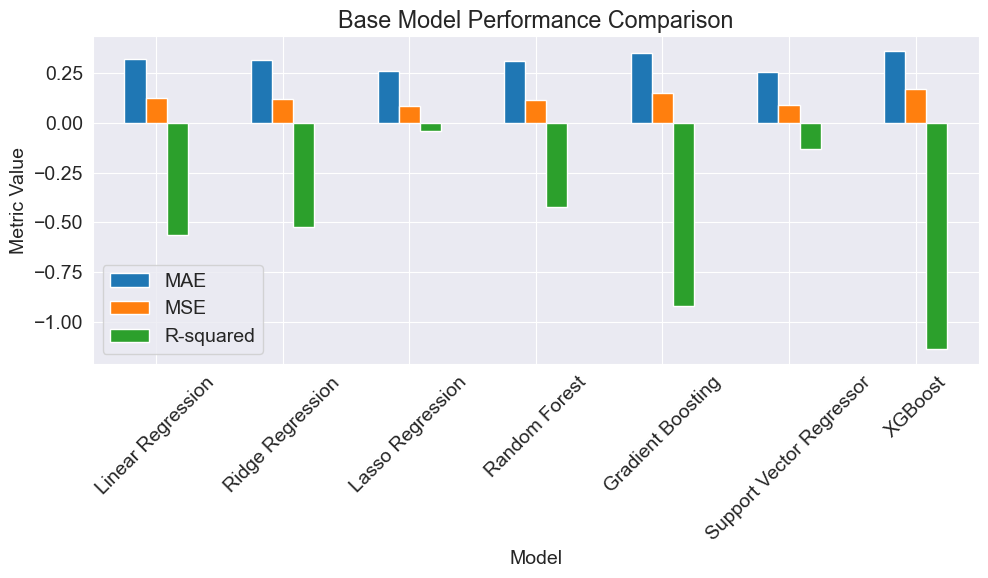

<Figure size 1200x600 with 0 Axes>

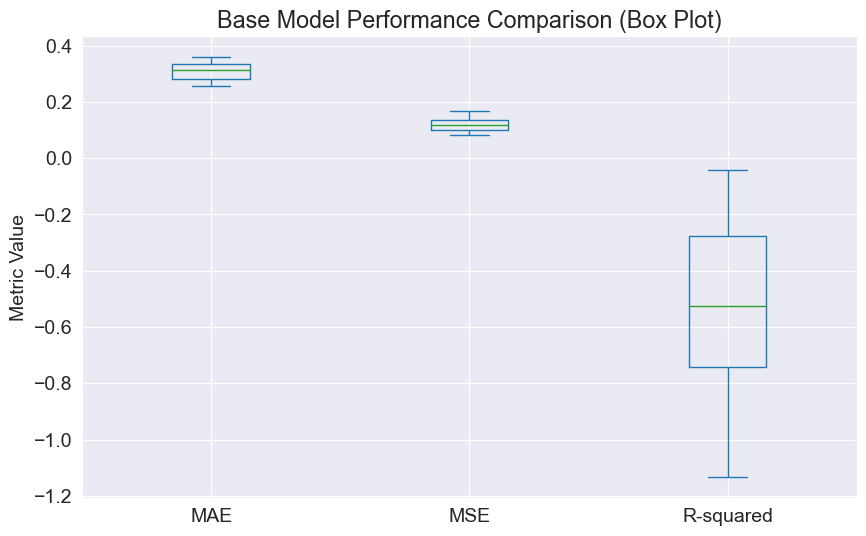

In [30]:
# Bar chart for MAE, MSE, and R-squared
plt.figure(figsize=(12, 6))
results_base_df[metrics_to_plot].plot(kind='bar', rot=45)
plt.title('Base Model Performance Comparison')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


# Box plot for MAE, MSE, and R-squared (alternative visualization)
plt.figure(figsize=(12, 6))
results_base_df[metrics_to_plot].plot(kind='box')
plt.title('Base Model Performance Comparison (Box Plot)')
plt.ylabel('Metric Value')
plt.show()

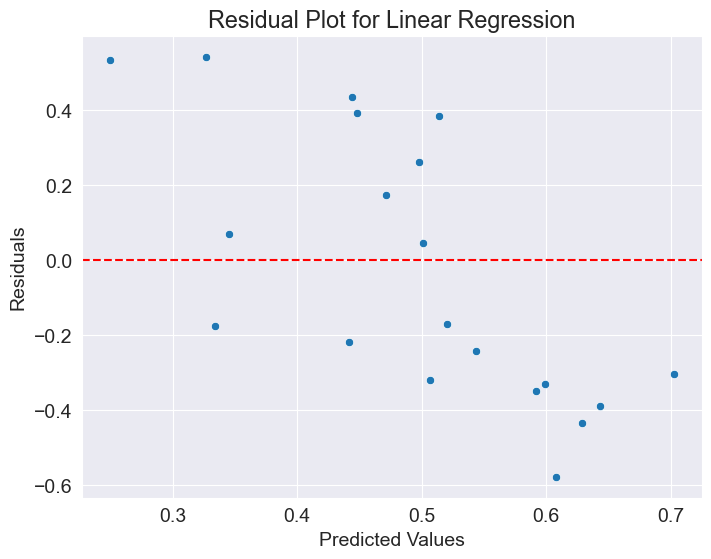

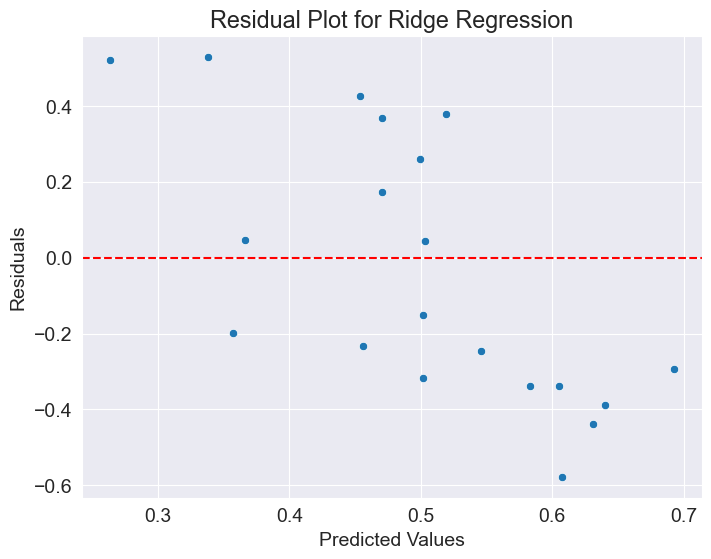

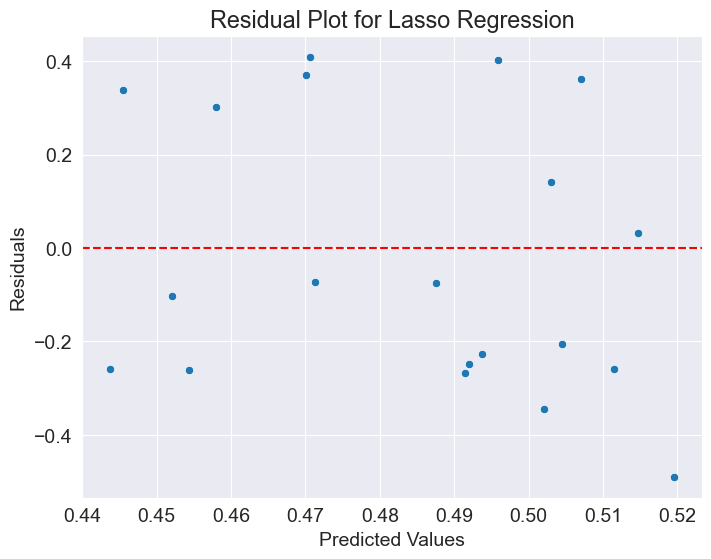

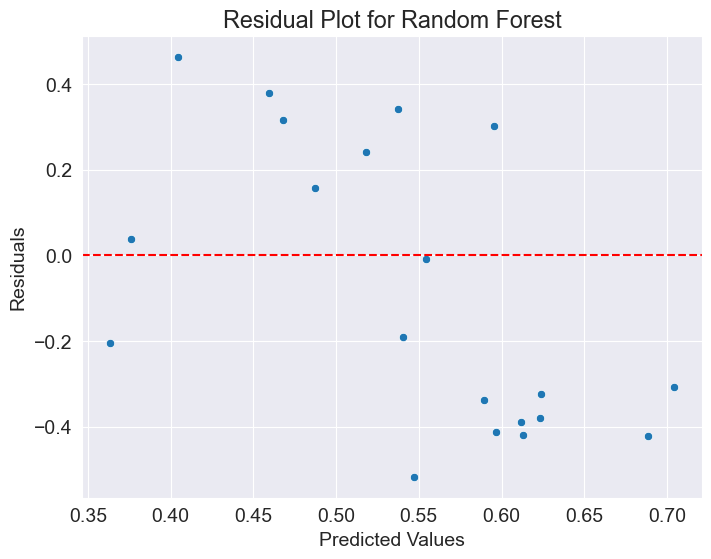

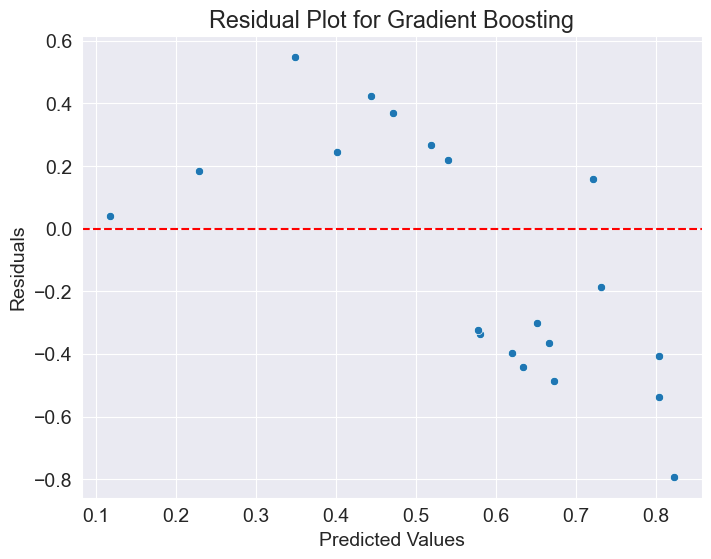

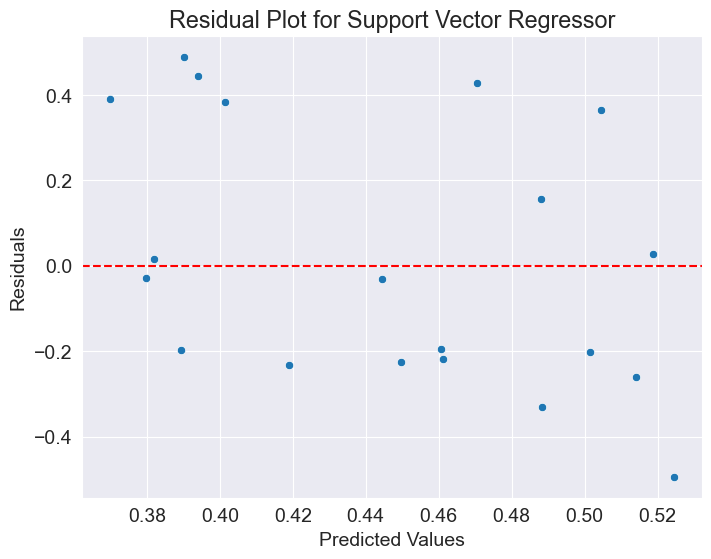

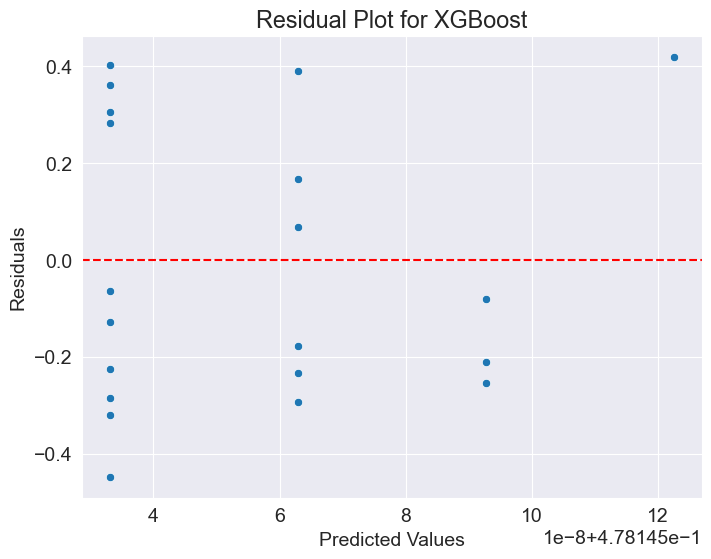

In [31]:
# Residual plots
for name, model in models.items():
    if name == "XGBoost":
        dtest = xgb.DMatrix(X_test, label=y_test)
        y_pred = best_model_xgb.predict(dtest)
    else:
        y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot for {name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

**How the Modeling Code Works:**

- The code first trains and evaluates both base and tuned models.

- It stores the tuned model objects (the trained models themselves) in the tuned_models dictionary.

- It then creates a DataFrame (tuned_results_df) that has the evaluation results of each tuned model.

- It uses idxmin() on the mse column of tuned_results_df to find the model with the minimum MSE.

- It then prints the name of the model as well as the model object itself.

- This code will now find and display the best-performing tuned model based on the Mean Squared Error (MSE) and print the model object

### Predictive System Development

In [32]:
# Develop a predictive system where users can input new data and receive productivity predictions

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor

# Load your pre-trained XGBoost model (replace with your actual model loading)
# Assuming 'best_model_xgb' is your best trained XGBoost model
# best_model_xgb = xgb.Booster() #replace with your model
# best_model_xgb.load_model("your_xgboost_model.json")


# Load dataset (replace 'new_garment_df.csv' with your actual file path)
try:
    garment_df = pd.read_csv('new_garment_df.csv')
except FileNotFoundError:
    print("Error: 'new_garment_df.csv' not found. Please ensure the file exists.")
    # Handle the error gracefully, e.g., exit or provide a default DataFrame.
    exit()


# Define input features and target variable
input_cols = ['team', 'smv', 'wip', 'over_time', 'incentive', 'idle_time',
              'idle_men', 'no_of_style_change', 'no_of_workers', 'month',
              'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_5',
              'day_of_week_6']
target_col = 'actual_productivity'

# Function to get user input and make predictions
def get_prediction():
    input_data = {}
    for col in input_cols:
        while True:
            try:
                value = float(input(f"Enter value for {col}: "))
                input_data[col] = value
                break
            except ValueError:
                print(f"Invalid input for {col}. Please enter a valid number.")

    new_df = pd.DataFrame([input_data]) # Creating a dataframe from dictionary
    dnew = xgb.DMatrix(new_df)
    # Make predictions
    # prediction = best_model_xgb.predict(new_df)  # Assuming you have trained the model
    prediction = best_model_xgb.predict(dnew)
    print("Predicted Productivity:", prediction[0])

if __name__ == "__main__":
    print("Welcome to the Productivity Prediction System!")
    get_prediction()

Welcome to the Productivity Prediction System!
Enter value for team: 8
Enter value for smv: 1.01
Enter value for wip: -0.01
Enter value for over_time: 0.75
Enter value for incentive: 98
Enter value for idle_time: 0
Enter value for idle_men: 0
Enter value for no_of_style_change: 0
Enter value for no_of_workers: 59
Enter value for month: 1
Enter value for day_of_week_1: 0
Enter value for day_of_week_2: 0
Enter value for day_of_week_3: 1
Enter value for day_of_week_5: 0
Enter value for day_of_week_6: 0
Predicted Productivity: 0.47814506


# The End